In [151]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [152]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import obspy.io.segy.core as op
from scipy import signal

In [153]:
# # Weak Signal
# file = 'data/das/FORGE1/FORGE_78-32_iDASv3-P11_UTC190428070308.sgy'
# stream = op._read_segy(file, format='segy')
# noisy = np.vstack([trace.data for trace in stream])

# noisy = noisy[200:960 + 200, 19500:20500]

# # noisy = noisy[200:960 + 200, 19500:21500]
# # noisy = signal.resample(noisy, 1000, axis=1)

# noisy.shape

In [154]:
# # Strong Signal
# file = 'data/das/FORGE1/FORGE_78-32_iDASv3-P11_UTC190423213209.sgy'
# stream = op._read_segy(file, format='segy')
# noisy = np.vstack([trace.data for trace in stream])

# noisy = noisy[200:960 + 200, 1500:2500]

# # noisy = noisy[200:960 + 200, 1500:3500]
# # noisy = signal.resample(noisy, 1000, axis=1)

# noisy.shape

In [155]:
# No Signal
file = 'data/das/FORGE1/FORGE_78-32_iDASv3-P11_UTC190419001218.sgy'
stream = op._read_segy(file, format='segy')
noisy = np.vstack([trace.data for trace in stream])
noisy = noisy[50:960 + 50, 8000:9000]

noisy.shape

(960, 1000)

In [156]:
noisy = noisy.T
noisy /= noisy.std()

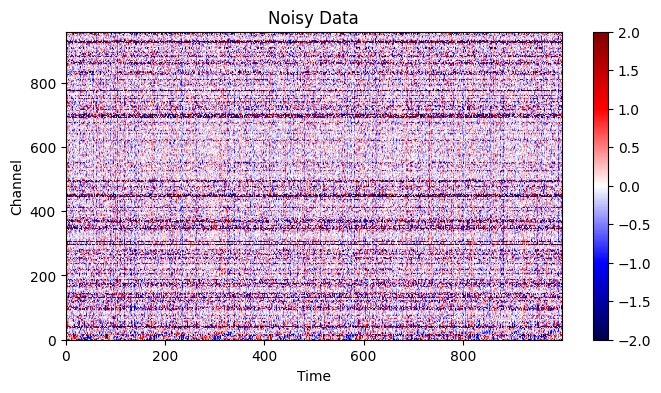

In [157]:
# clip = np.percentile(noisy, 99.)
clip = 2

plt.figure(figsize=(8, 4))
plt.imshow(noisy.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
plt.title('Noisy Data')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.colorbar()
plt.show()

In [158]:
pre_processed = np.array(noisy)

In [159]:
import pyseistr as ps

# BP
pre_processed = ps.bandpassc(pre_processed, 0.0005, 0, 200, 6, 6, 0, 0)

## SOMF
# dip = ps.dip2dc(pre_processed, 2, 10, 2, 0.01, 1, 0.000001, [50,50,1], 1)
# pre_processed = ps.somf2dc(pre_processed, dip, 8, 2, 0.01, 1)

# ## FK
# pre_processed = pre_processed - ps.fkdip(pre_processed, 0.02)

median = np.median(pre_processed, axis=1, keepdims=True)
pre_processed = pre_processed - median

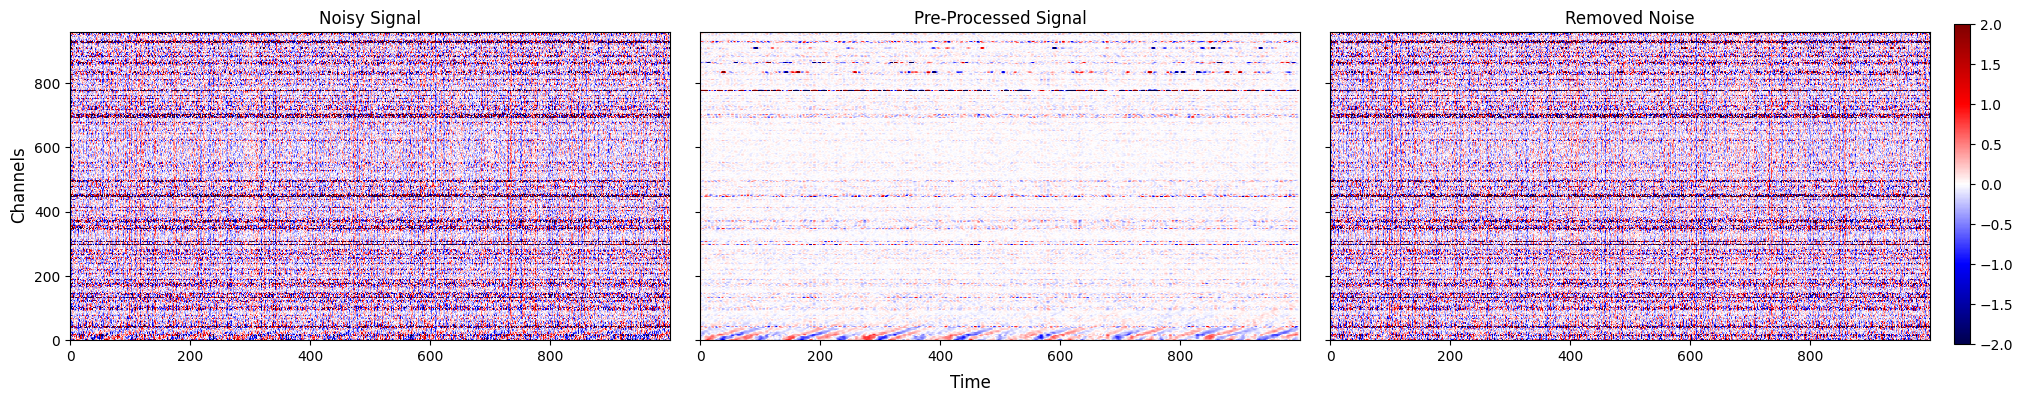

In [160]:
diff = noisy - pre_processed

# clip = np.percentile(noisy, 99.)
clip = 2

fig, axes = plt.subplots(1, 3, figsize=(24, 4), sharex=True, sharey=True)

im3 = axes[0].imshow(noisy.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[0].set_title('Noisy Signal')

axes[1].imshow(pre_processed.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[1].set_title('Pre-Processed Signal')

axes[2].imshow(diff.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[2].set_title('Removed Noise')

fig.supxlabel('Time', y=-0.02)
fig.supylabel('Channels', x=0.1)

cbar = fig.colorbar(im3, ax=axes, orientation='vertical', fraction=0.01)
cbar.ax.set_position([0.91, 0.1, 0.2, 0.8])

plt.subplots_adjust(wspace=0.05)
plt.show()

In [161]:
# local normalization
from scipy.ndimage import uniform_filter, gaussian_filter

patch_size = 32

local_mean = uniform_filter(pre_processed, size=patch_size) 
local_var = uniform_filter(pre_processed**2, size=patch_size) - local_mean**2

# local_mean = gaussian_filter(pre_processed, sigma=patch_size/6)
# local_var = gaussian_filter(pre_processed**2, sigma=patch_size/6) - local_mean**2

local_std = np.sqrt(np.maximum(local_var, 0))  # Ensure non-negative variance

pre_processed_n = (pre_processed - 0) / (local_std + 1e-8)

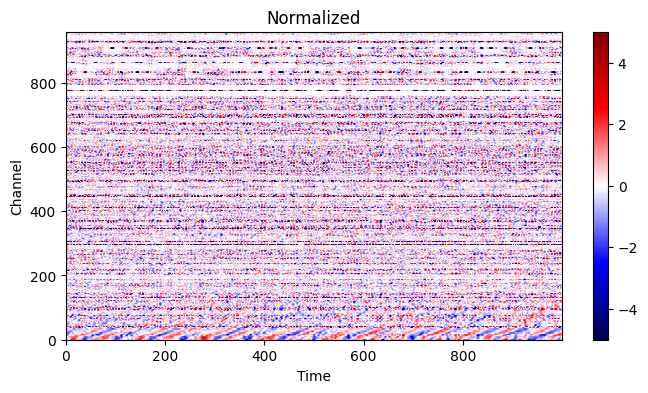

In [162]:
clip = 5
# clip = np.percentile(noisy, 99.)

plt.figure(figsize=(8, 4))
plt.imshow(pre_processed_n.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
plt.title('Normalized')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.colorbar()
plt.show()

In [163]:
y = torch.Tensor(pre_processed_n).unsqueeze(0).unsqueeze(0)

In [164]:
from models import UNetModECA, UNetMod, FC_ECA, FC_ECA1
from denoisers.dip import DIP, SGDIP, PatchDIP, losses, schedules

# architectures
net = UNetMod(in_ch=1, out_ch=1, hidden_ch=8, n_layers=4)
net1 = UNetModECA(in_ch=1, out_ch=1, hidden_ch=8, n_layers=4)

net_conv = UNetMod(in_ch=1, out_ch=1, hidden_ch=8, n_layers=4)

# schedules
linear_1_10 = schedules.Linear(1, 10)
linear_1_2 = schedules.Linear(1, 2)
linear_1_5 = schedules.Linear(1, 5)
cos_1_5 = schedules.Cos(1, 5)

# losses
mse = losses.MSE()
nmse = losses.NMSE()
mse_ae = losses.Compose(mse, losses.AE())
nmse_ae = losses.Compose(nmse, losses.AE())
mse_ae_ip = losses.Interpolate(mse, losses.AE())
mse_tv = losses.Compose(mse, losses.TV())

# variants
# dip = DIP(net1, mse, max_epochs=1000, early_stopping=True)
# dip = SGDIP(net1, mse_ae_ip.with_schedule(schedules.Cos(0, 1)), max_epochs=400)
# dip = SGDIP(net1, mse_ae.with_alpha(schedules.Cos(1, 10)), max_epochs=400, early_stopping=True)
# dip = SGDIP(net1, mse_ae, max_epochs=1000)
# dip = PatchDIP(net2, mse, 1, batch_size=1024, kurtosis_threshold=0.2, use_diff=True)


options = {
    "mode": "local",
    "config": {
        "out_dir": "output/das/refine/strategy",
        "project": "",
        "entity": "",
        "group": "",
        "dataset": "",
        "denoiser_id": 0,
        "data_id": 0,
    },
    "metrics": {},
    "log_output": False,
}

Running: 0 - SGDIP (k=3, r=0.7) - MSE + AE (alpha=Cos (1, 10)) - UNetMod ECA 


100%|██████████| 300/300 [01:32<00:00,  3.25it/s]


Summary: {'runtime': '00:01:32'}



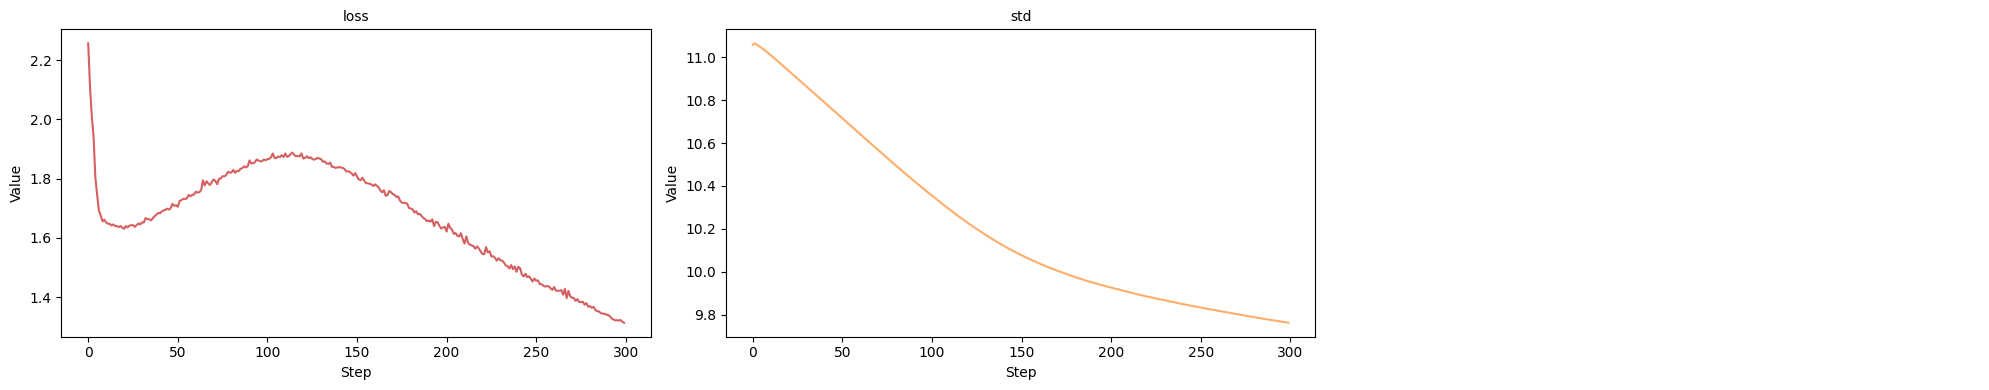

In [165]:
sgdip = SGDIP(net1, mse_ae.with_alpha(schedules.Cos(1, 10)), max_epochs=300, reference=y, ratio=0.7)  # ratio=1 for SOMF

x_hat, _, _ = sgdip.denoise(y, logging_options=options)
x_hat = x_hat.detach().clone().cpu()

In [166]:
# Rescale
denoised = x_hat.clone().squeeze().numpy()

denoised = denoised*local_std

diff = noisy - denoised

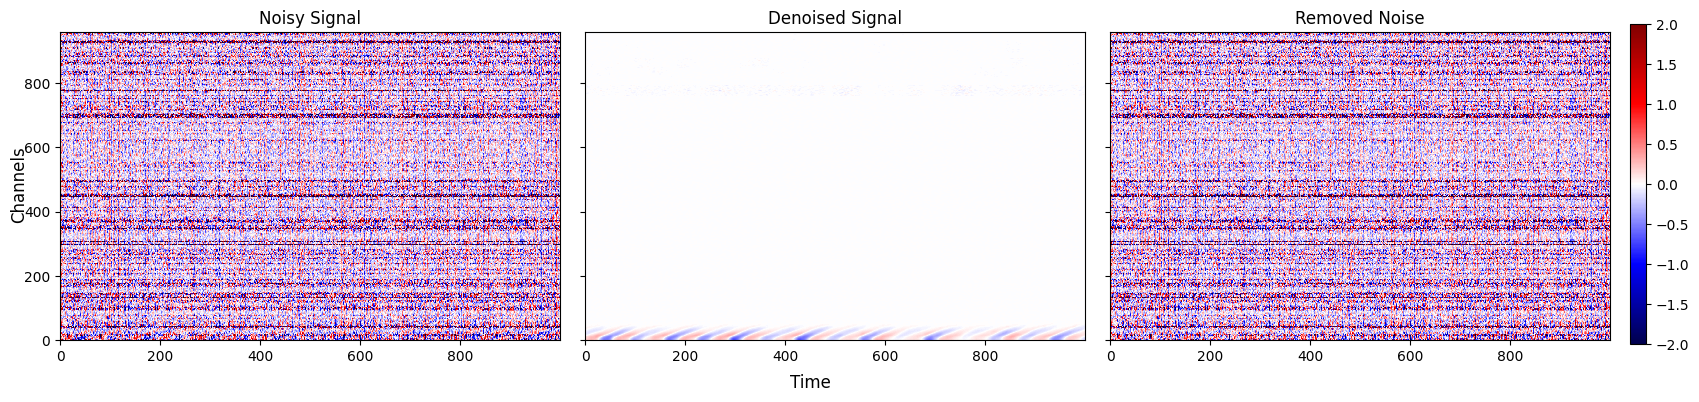

In [167]:
clip = 2

fig, axes = plt.subplots(1, 3, figsize=(20, 4), sharex=True, sharey=True)

im1 = axes[0].imshow(noisy.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[0].set_title('Noisy Signal')

axes[1].imshow(denoised.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[1].set_title('Denoised Signal')

axes[2].imshow(diff.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[2].set_title('Removed Noise')

fig.supxlabel('Time', y=-0.02)
fig.supylabel('Channels', x=0.1)

cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.01)
cbar.ax.set_position([0.91, 0.1, 0.2, 0.8])

plt.subplots_adjust(wspace=0.05)
plt.show()

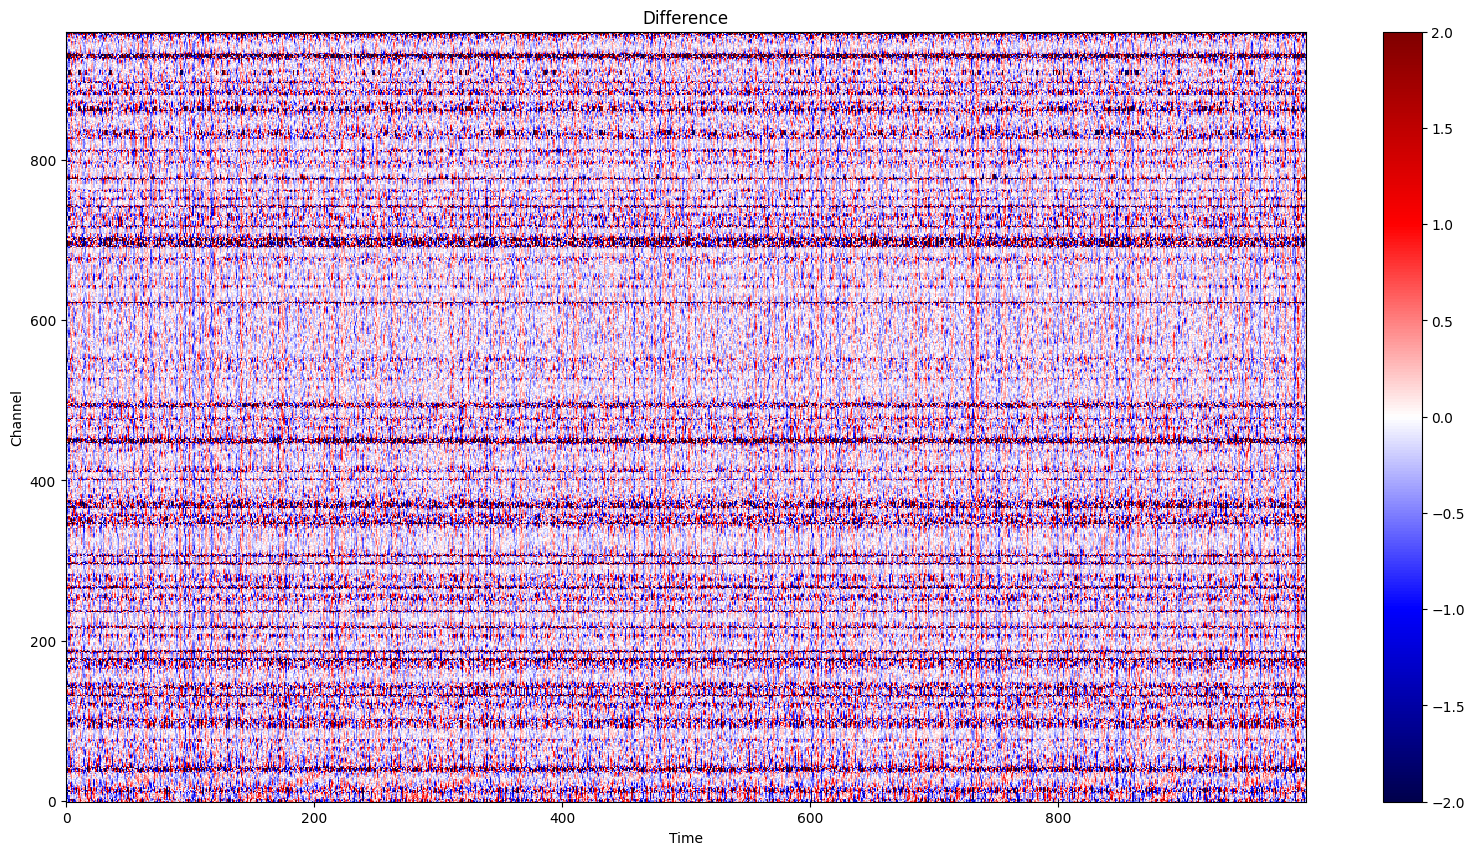

In [168]:
diff = noisy - denoised

clip = 2
plt.figure(figsize=(20, 10))
plt.imshow(diff.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
plt.title('Difference')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.colorbar()
plt.show()

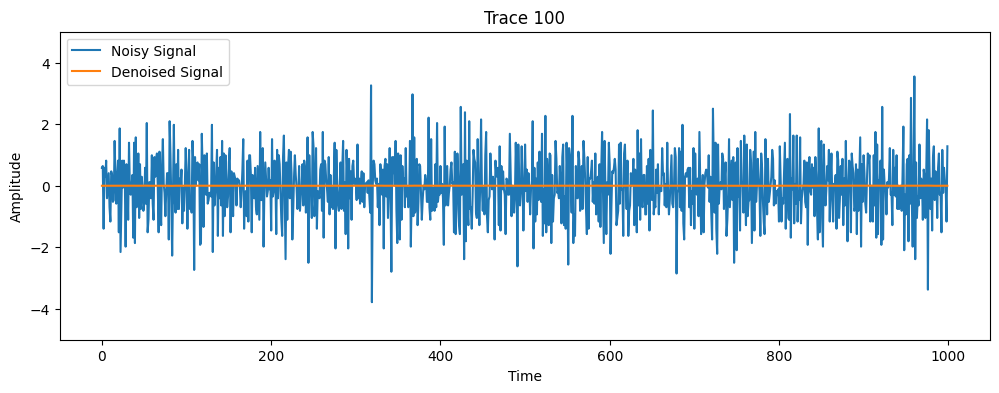

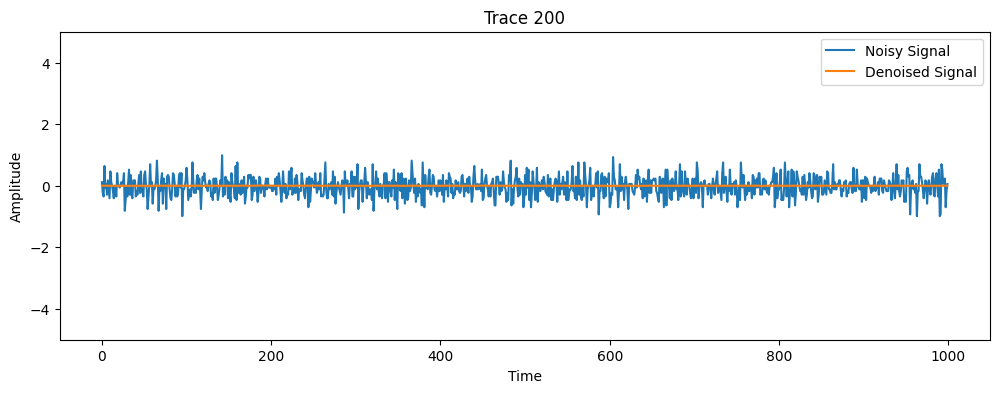

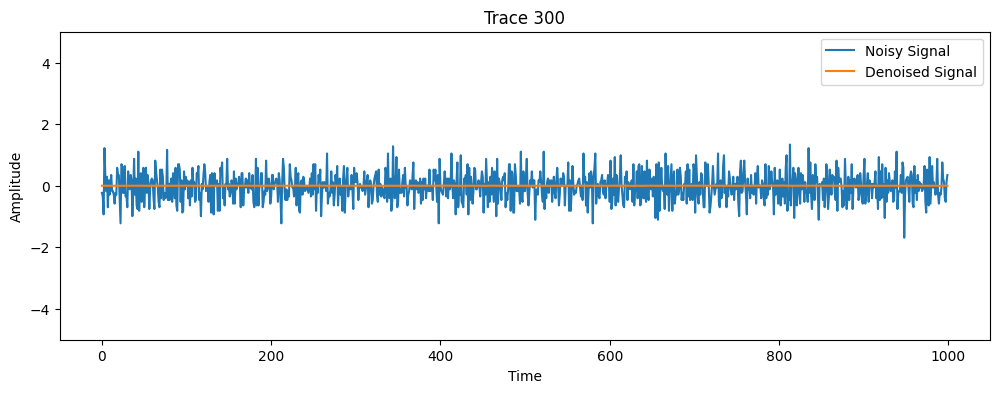

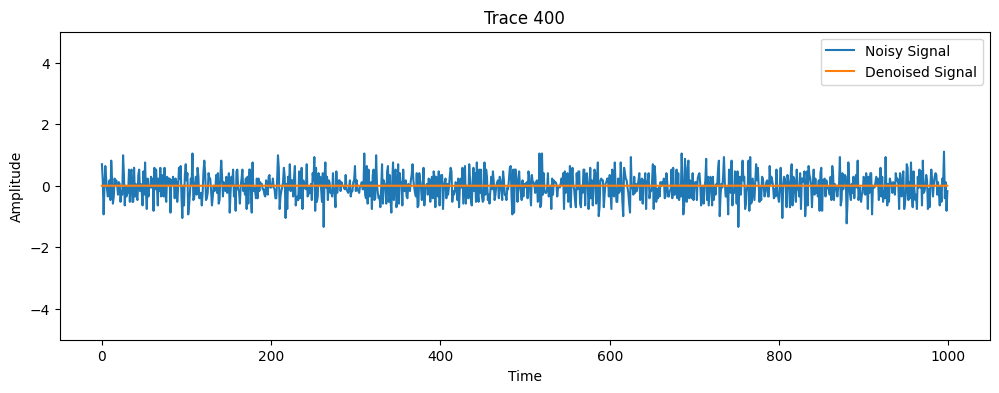

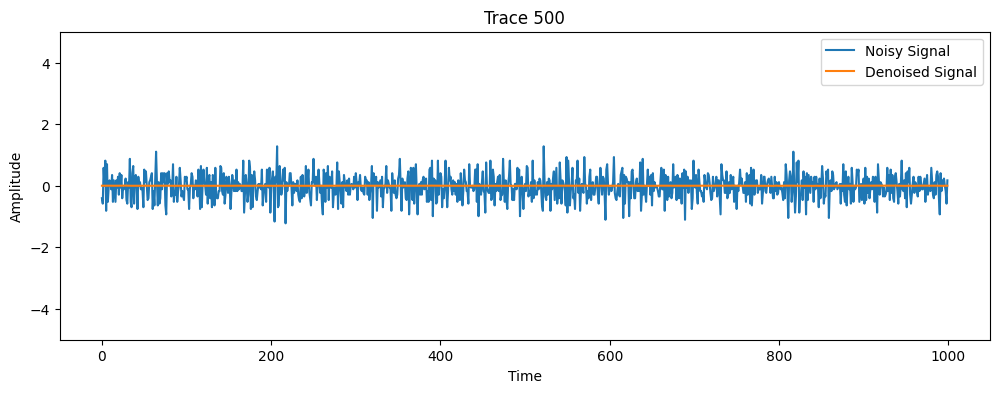

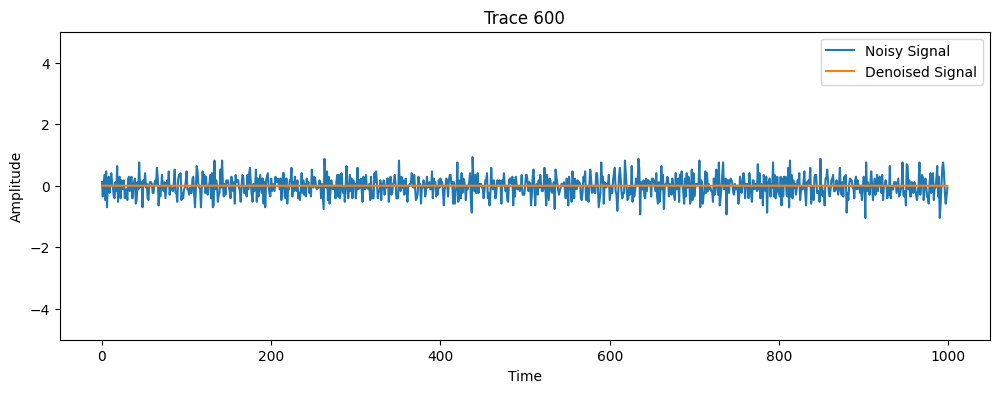

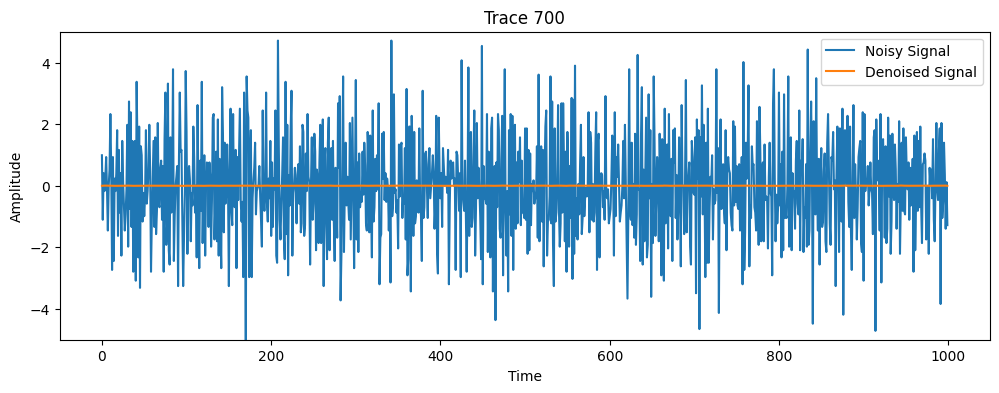

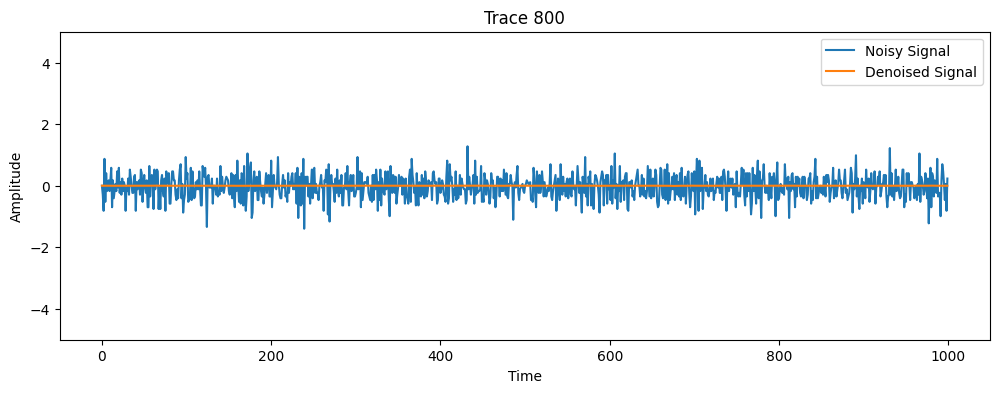

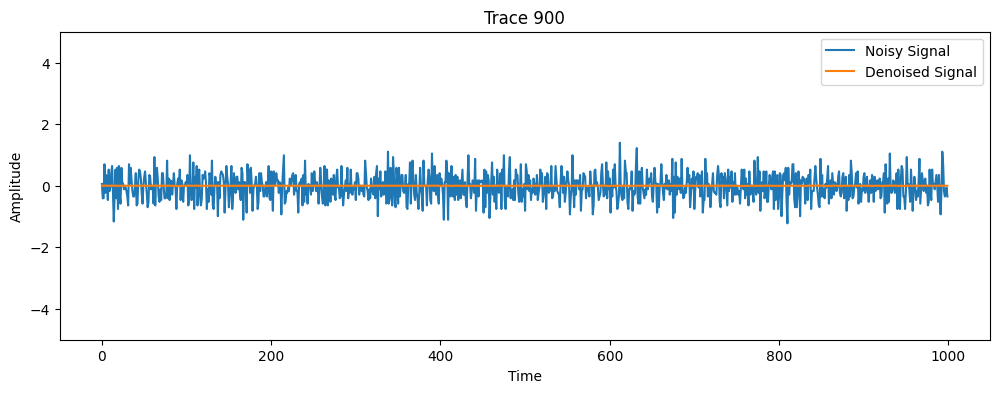

In [169]:
from scipy.ndimage import gaussian_filter1d

channels = [i for i in range(100, 1000, 100)]

for channel in channels:
    denoised_trace = denoised.T[channel, :]
    noisy_trace = noisy.T[channel, :]
    # smoothed = gaussian_filter1d(noisy_trace, sigma=2)

    plt.figure(figsize=(12, 4))
    plt.plot(noisy_trace, label='Noisy Signal')
    # plt.plot(smoothed, label='Smoothed Noisy Signal')
    plt.plot(denoised_trace, label='Denoised Signal')
    plt.title(f'Trace {channel}')
    plt.ylabel('Amplitude')
    plt.xlabel('Time')
    plt.ylim(-5, 5)
    plt.legend()
    plt.show()

In [170]:
import pyseistr as ps

# BP
idf = ps.bandpassc(noisy, 0.0005, 0, 200, 6, 6, 0, 0)

## SOMF
dip = ps.dip2dc(idf, 2, 10, 2, 0.01, 1, 0.000001, [50,50,1], 1)
idf = ps.somf2dc(idf, dip, 8, 2, 0.01, 1)

## FK
idf = idf - ps.fkdip(idf, 0.02)

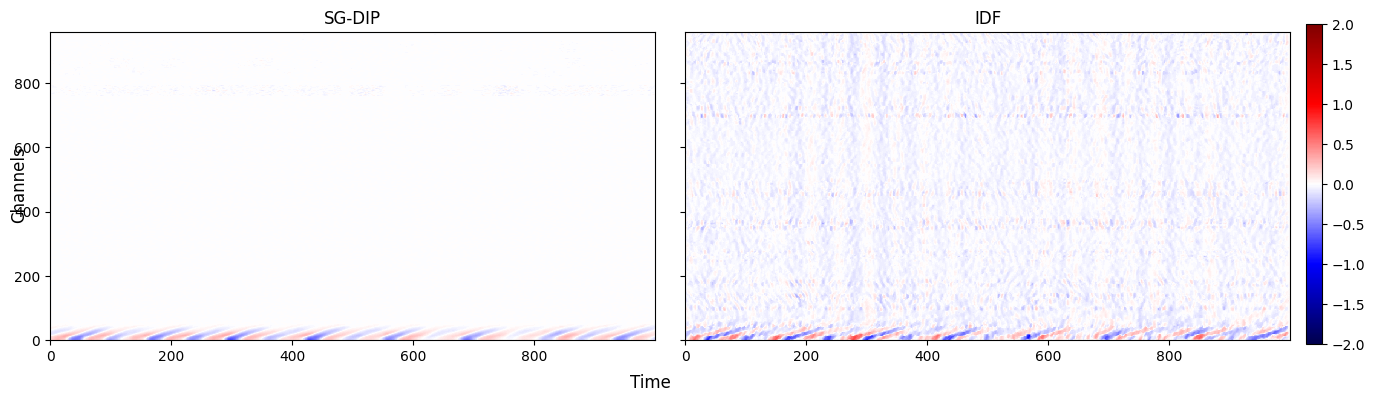

In [171]:
clip = 2

fig, axes = plt.subplots(1, 2, figsize=(16, 4), sharex=True, sharey=True)

im1 = axes[0].imshow(denoised.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[0].set_title('SG-DIP')

axes[1].imshow(idf.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
axes[1].set_title('IDF')

fig.supxlabel('Time', y=-0.02)
fig.supylabel('Channels', x=0.1)

cbar = fig.colorbar(im1, ax=axes, orientation='vertical', fraction=0.01)
cbar.ax.set_position([0.91, 0.1, 0.2, 0.8])

plt.subplots_adjust(wspace=0.05)
plt.show()

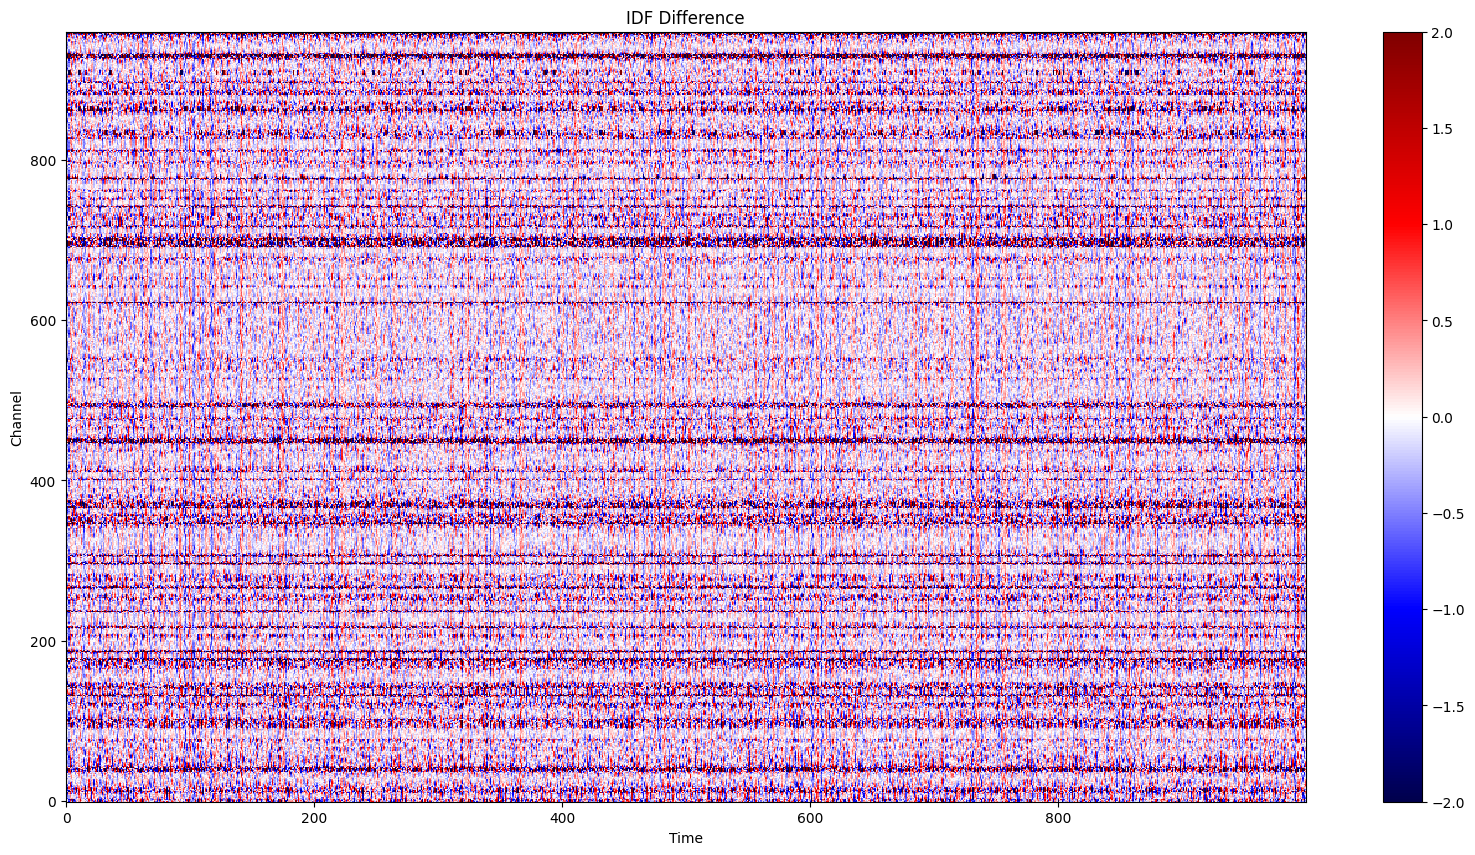

In [172]:
diff = noisy - idf

clip = 2
plt.figure(figsize=(20, 10))
plt.imshow(diff.T, origin='lower', aspect='auto', cmap='seismic', interpolation='none', vmin=-clip, vmax=clip)
plt.title('IDF Difference')
plt.xlabel('Time')
plt.ylabel('Channel')
plt.colorbar()
plt.show()